# MMDetection Tutorial

Welcome to MMDetection! This is the official colab tutorial for using MMDetection. In this tutorial, you will learn
- Perform inference with a MMDet detector.
- Train a new detector with a new dataset.

Let's start!


## Install MMDetection

In [1]:
%%bash
# install dependencies: (use cu101 because colab has CUDA 10.1)
pip install -U torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
pip install mmcv-full

# Install mmdetection
rm -rf mmdetection
git clone https://github.com/open-mmlab/mmdetection.git
cd mmdetection && pip install -e .

# install Pillow 7.0.0 back in order to avoid bug in colab
pip install Pillow==7.0.0

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Obtaining file:///content/mmdetection
  Running setup.py develop for mmdet


Cloning into 'mmdetection'...


## RESTART THE RUNTIME AFTER LIBS INSTALLATION

In [27]:
# Turn off warnings
import warnings
warnings.filterwarnings("ignore")

# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

import matplotlib.pyplot as plt
import numpy as np
import cv2

1.5.1+cu101 True
2.17.0
11.1
GCC 7.5


In [28]:
idx_category = {
    1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat',
    10: 'traffic light', 11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench',
    16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra',
    25: 'giraffe', 27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis',
    36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard',
    43: 'tennis racket', 44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl',
    52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza',
    60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 67: 'dining table', 70: 'toilet',
    72: 'tv', 73: 'laptop', 74: 'mouse', 75: 'remote', 76: 'keyboard', 77: 'cell phone', 78: 'microwave', 79: 'oven',
    80: 'toaster', 81: 'sink', 82: 'refrigerator', 84: 'book', 85: 'clock', 86: 'vase', 87: 'scissors', 88: 'teddy bear',
    89: 'hair drier', 90: 'toothbrush'
}
category_mapping = {idx: category for idx, category in enumerate(idx_category.values())}
idx_mappping = {category: idx for idx, category in category_mapping.items()}

In [29]:
animals = ['bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'teddy bear', ]
animals_idx = {idx_mappping[category]:category for category in animals}

dogs = ['dog', ]
dogs_idx = {idx_mappping[category]:category for category in dogs}

## Perform inference with a MMDet detector
MMDetection already provides high level APIs to do inference and training.

In [30]:
#download weights
%%bash

mkdir -p checkpoints
wget -q -c https://download.openmmlab.com/mmdetection/v2.0/htc/htc_x101_64x4d_fpn_16x1_20e_coco/htc_x101_64x4d_fpn_16x1_20e_coco_20200318-b181fd7a.pth \
        -O checkpoints/htc.pth

## Init the model

In [31]:
from mmdet.apis import inference_detector, init_detector

# Choose to use a config and initialize the detector
config = '/content/mmdetection/configs/htc/htc_x101_64x4d_fpn_16x1_20e_coco.py'
# Setup a checkpoint file to load
checkpoint = '/content/checkpoints/htc.pth'
# initialize the detector
model = init_detector(config, checkpoint, device='cuda:0')

Use load_from_local loader


## Choose the path of your input image

In [78]:
# Use the detector to do inference
img = '/content/1.jpg'
#img = '/content/mmdetection/demo/demo.jpg'
predicted_instances = inference_detector(model, img)

## Choose the target class(es)

In [79]:
def select_instances(
    predicted_instances: tuple,
    target_classes: list=['dog', ],
    treshold_confidence: float=1e-2,
    idx_mappping: dict=idx_mappping,
) -> tuple:

    """
    Selects target classes above treshold confidence from output mmdetection model
    """

    bboxes, masks = predicted_instances

    target_idxs = [idx_mappping[target_class] for target_class in target_classes]

    target_bboxes, target_masks = [], []

    for target_idx in target_idxs:
        filtered_bboxes, filtered_masks = [], []
        for bbox, mask in zip(bboxes[target_idx], masks[target_idx]):
            if len(bbox) == 0:
                continue
            x_l, y_l, x_r, y_r, sc = bbox
            if sc > treshold_confidence:
                filtered_bboxes.append(bbox)
                filtered_masks.append(mask)
        target_bboxes.append(np.array(filtered_bboxes))
        target_masks.append(np.array(filtered_masks))

    target_result = (target_bboxes, target_masks)

    return target_result

def plot_result(
    img: str,
    result: tuple, 
    target_classes: list,
) -> np.array:

    """
    plot result 
    """

    bboxes, masks = result
    assert len(bboxes) == len(target_classes)

    image = cv2.imread(img)
        
    for target_idx, target_class in enumerate(target_classes):
        for bbox, mask in zip(bboxes[target_idx], masks[target_idx]):
            if len(bbox) == 0:
                continue
            x_l, y_l, x_r, y_r, sc = bbox
            color = np.random.randint(0, 256, 3)
            cv2.rectangle(
                image, (x_l, y_l), (x_r, y_r), color.tolist(), 2
            )
            image[mask] = image[mask] * 0.7 + color * 0.3
            x, y = map(lambda x: int(np.mean(x).item()), np.nonzero(mask))

            cv2.putText(
                image, target_class, (x_l, y_l),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, color.tolist(), 2, cv2.LINE_AA,
            )

    return image


def is_animal_here(
    predicted_instances: tuple,
    animals: list=animals,
    treshold_confidence: float=1e-2,
    idx_mappping: dict=idx_mappping,
) -> bool:

    """
    is animal on predicted instances? 
    """

    target_idxs = [idx_mappping[target_class] for target_class in animals]

    bboxes, masks = predicted_instances

    for target_idx in target_idxs:
        for bbox in bboxes[target_idx]:
            if len(bbox) == 0:
                continue
            x_l, y_l, x_r, y_r, sc = bbox
            if sc > treshold_confidence:
                return True

    return False

In [80]:
target_classes = animals
treshold_confidence = 7e-2

target_result = select_instances(predicted_instances, target_classes, treshold_confidence)

print(f'Is dog here: {is_animal_here(predicted_instances, dogs, treshold_confidence)}, \
        Is animal here: {is_animal_here(predicted_instances, animals, treshold_confidence)}')

Is dog here: False,         Is animal here: True


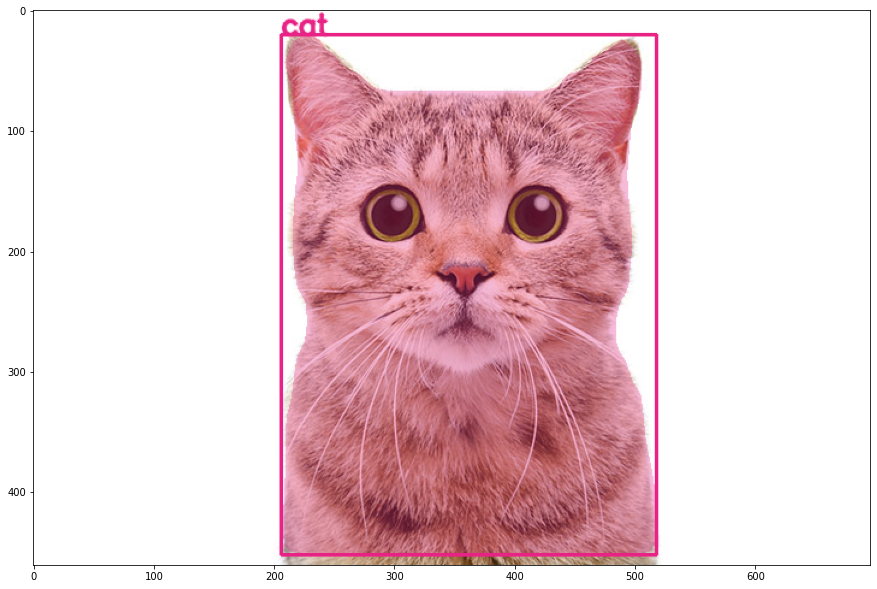

In [81]:
image = plot_result(img, target_result, target_classes)
plt.figure(figsize=(15,20))
plt.imshow(image[..., ::-1])